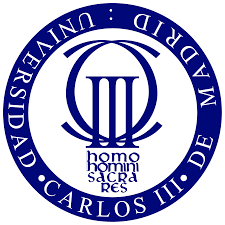

# PRÁCTICA 1: Procesamiento de datos mediante Apache Spark

Autores: Pablo Hidalgo Delgado, Till Niklas Kobele, Juan Romero Sanz, Juan María Villard Bardón.

NIAs: 100451225, 100548395, 100535977, 100439614.

Grupo de prácticas: D


## Índice
- [1. Introducción](#1.-Introducción)

- [2. Lectura de los datos](#2.-Lectura-de-los-datos)

    - [2.1 Trip data](#2.1-Trip-data)
 
    - [2.2 Zone data](#2.2-Zone-data)

- [3. Análisis exploratorio de los datos](#2.-Análisis-exploratorio-de-los-datos)
      
    - [3.1 Trip data](#3.1-Trip-data)
 
    - [3.2 Zone data](#3.2-Zone-data)

- [4. Preproceso de los datos](#4.-Preproceso-de-los-datos)

    - [4.1 Conversión de formato de fecha al formato UNIX (timestamp)](#4.1-Conversión-de-formato-de-fecha-al-formato-UNIX-(timestamp))
      
    - [4.2 Unión de las 2 fuentes de datos](#4.2-Unión-de-las-fuentes-de-datos)
 
    - [4.3 Conversión de millas a kilómetros](#4.2-Conversión-de-millas-a-kilómetros)

- [5. Implementación de las consultas](#5.-Implementación-de-las-consultas)

    - [5.1 Velocidad media de los taxis en función de la hora](#5.1-Velocidad-media-de-los-taxis-en-función-de-la-hora)
 
        - [5.1.1 Dataframes de Spark](#5.1.1-Dataframes-de-Spark)
          
        - [5.1.2 SparkSQL](#5.1.2-SparkSQL)
     
        - [5.1.3 RDDs](#5.1.3-RDDs)
      
    - [5.2 Viajes en taxi más comunes](#5.2-Viajes-en-taxi-más-comunes)
 
        - [5.2.1 Dataframes de Spark](#5.2.1-Dataframes-de-Spark)
          
        - [5.2.2 SparkSQL](#5.2.2-SparkSQL)
     
        - [5.2.3 RDDs](#5.2.3-RDDs)
     
    - [5.3 Cantidad total media pagada en función del número de pasajeros](#5.2-Cantidad-total-media-pagada-en-función-del-número-de-pasajeros)
 
        - [5.3.1 Dataframes de Spark](#5.3.1-Dataframes-de-Spark)
          
        - [5.3.2 SparkSQL](#5.3.2-SparkSQL)
     
        - [5.3.3 RDDs](#5.3.3-RDDs)

- [6. Análisis del rendimiento comparando las distintas consultas](#6.-Análisis-del-rendimiento-comparando-las-distintas-consultas)




.

.

.


  
- [Conclusión](#conclusión)

## 1. Introducción

Este proyecto consiste en un análisis de los datos de viajes de taxis de YellowCab en la ciudad de Nueva York, utilizando Apache Spark para procesar grandes volúmenes de datos. Se realizan estudios sobre:

- Velocidad media de los taxis en función de la hora.
  
- Viajes en taxi más comunes.

- Cantidad total media pagada en función del número de pasajeros.
  
Esto se consigue mediante la implementación de consultas mediante Spark SQL, DataFrames y RDDs. El objetivo principal es realizar un análisis de rendimiento comparativo entre estas técnicas.


`revisar introducción`

## 2. Lectura de los datos

### 2.1 Trip data

En primer lugar, leemos el conjunto de datos principal, que se encontrará almacenado en el archivo `data/tripdata_2017-01.csv`. Este fichero contiene datos estructurados sobre los viajes en taxi en la ciudad de Nueva York durante el mes de Enero de 2017.

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

cores = 3
spark = SparkSession.builder.master(f'local[{cores}]').getOrCreate()
#spark.conf.set('spark.cores.max', '1')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

spark

In [2]:
# Definimos la ruta del archivo CSV
route_trip_data = "data/tripdata_2017-01.csv"

# Leemos el archivo CSV como un DataFrame de Spark
trip_data_df = spark.read.csv(route_trip_data, header=True, inferSchema=True)

print(type(trip_data_df))

<class 'pyspark.sql.dataframe.DataFrame'>


Se obtiene un objeto dataframe de Spark con los datos almacenados.

### 2.2 Zone data

De la misma manera, leemos el archivo CSV que contiene información sobre las distintas zonas de la ciudad de Nueva York. Este archivo se incluye en la práctica con el objetivo de ampliar nuestro dataset principal, añadiendo información sobre las zonas en que se tomaron los taxis.

In [3]:
# Leemos el fichero con información sobre las zonas
route_zone_data = "data/taxi_zone_lookup.csv"

# Leemos el archivo CSV como un DataFrame de Spark
zone_data_df = spark.read.csv(route_zone_data, header=True, inferSchema=True)

## 3. Análisis exploratorio de los datos

Antes de empezar con las operaciones y el análisis, vamos a realizar un pequeño análisis exploratorio de datos (EDA). De esta manera, podremos investigar y resumir las características más importantes de nuestros datasets. Esto nos servirá para comprender mejor los conjuntos de datos e identificar potenciales operaciones de preprocesamiento que serán necesarias para nuestra práctica.

### 3.1 Trip data

In [4]:
trip_data_df.toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,12.5,0.0,0.5,2.00,0.00,0.3,15.30
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,5.0,0.0,0.5,1.45,0.00,0.3,7.25
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,5.5,0.0,0.5,1.00,0.00,0.3,7.30
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,6.0,0.0,0.5,1.70,0.00,0.3,8.50
4,2,2017-01-01 00:00:00,2017-01-01 00:00:00,1,0.02,2,N,249,234,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971005,2,2017-01-17 13:16:22,2017-01-17 13:35:14,1,3.43,1,N,264,264,2,14.5,0.0,0.5,0.00,0.00,0.3,15.30
971006,2,2017-01-17 13:16:23,2017-01-17 13:23:01,1,0.78,1,N,161,237,1,6.0,0.0,0.5,1.36,0.00,0.3,8.16
971007,2,2017-01-17 13:16:23,2017-01-17 13:23:51,1,0.95,1,N,237,229,2,6.5,0.0,0.5,0.00,0.00,0.3,7.30
971008,2,2017-01-17 13:16:23,2017-01-17 13:32:45,1,1.68,1,N,170,48,1,11.5,0.0,0.5,2.46,0.00,0.3,14.76


In [5]:
trip_data_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



El conjunto de datos se compone de **971010 filas y 17 atributos**. En cuanto a las columnas, 8 contienen valores de tipo double, 6 contienen valores enteros (integer), 2 contienen valores de tipo timestamp (fecha) y 1 contiene valores de tipo string. Inspeccionando la página web [NYC TLC Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), podemos encontrar el significado de todos estos atributos.

In [6]:
trip_data_df.describe().toPandas()

,summary,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,count,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010
1,mean,1.5569510097733288,1.6859888157691476,3.0312848786315643,1.0447286845655555,None,160.37803112223355,158.5567120832947,1.3719735121162502,13.108188154601873,0.20999277041431086,0.4972142408420099,1.6790282695338843,0.28018088382194434,0.29962863410438667,16.078110822698864
2,stddev,0.4967462497187955,1.2917046837574053,3.785847233211693,0.461631265374306,None,67.93819834229247,72.27682104933919,0.5033263270235144,546.7369331190969,0.26163400368201367,0.04058594644609136,2.5713641104199754,1.7369077136569446,0.01446841089918546,546.7901022658588
3,min,1,0,0.0,1,N,1,1,1,-120.0,-1.0,-0.5,-6.06,0.0,-0.3,-120.3
4,max,2,9,151.7,99,Y,265,265,4,538579.2,55.54,0.5,366.0,905.54,0.3,538580.0


### 3.2 Zone data

In [7]:
zone_data_df.toPandas()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,N/A,N/A


In [8]:
zone_data_df.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



El conjunto de datos se compone de **265 filas y 4 atributos**. Cada fila se corresponde con una zona distinta de Nueva York, identificada por la columna `LocationID`

In [9]:
zone_data_df.describe().toPandas()

,summary,LocationID,Borough,Zone,service_zone
0,count,265,265,265,265
1,mean,133.0,None,None,None
2,stddev,76.643112323722,None,None,None
3,min,1,Bronx,Allerton/Pelham Gardens,Airports
4,max,265,Unknown,Yorkville West,Yellow Zone


## 4. Preproceso de los datos

Antes de empezar con las distintas operaciones, realizamos un preproceso de los datos para tenerlos en el formato más adecuado y deseado para la realización de la práctica.

### 4.1 Conversión de formato de fecha al formato UNIX (timestamp)

En el apartado anterior, observamos que las columnas **tpep_pickup_datetime** y **tpep_dropoff_datetime** contienen fechas (como era de esperar) en formato cadena (string) con el formato aaaa-mm-dd hh:mm:ss. 

Para poder trabajar y realizar operaciones matemáticas con estos valores de fechas, es necesario convertirlas a un formato que permita cálculos y comparaciones eficientes, como el formato UNIX (timestamp), el cual representa el número de segundos transcurridos desde el 1 de enero de 1970. Añadimos 2 columnas con estos valores a nuestro dataset.

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

datetime_to_UNIX = lambda dt: int(dt.timestamp())
datetime_to_UNIX_udf = udf(datetime_to_UNIX, IntegerType())

trip_data_df_unix = (
    trip_data_df
    .withColumn("tpep_pickup_datetime_unix", datetime_to_UNIX_udf(trip_data_df['tpep_pickup_datetime']))
    .withColumn("tpep_dropoff_datetime_unix", datetime_to_UNIX_udf(trip_data_df['tpep_dropoff_datetime']))
)

trip_data_df_unix.printSchema()
trip_data_df_unix.select("tpep_pickup_datetime_unix", "tpep_dropoff_datetime_unix").limit(5).toPandas()


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- tpep_pickup_datetime_unix: integer (nullable = true)
 |-- tpep_dropoff_datetime_unix: integer (nullable = true)



,tpep_pickup_datetime_unix,tpep_dropoff_datetime_unix
0,1483960408,1483961145
1,1483961547,1483961761
2,1483961900,1483962125
3,1483962733,1483963056
4,1483228800,1483228800


### 4.2 Unión de las 2 fuentes de datos

Para ampliar nuestro conjunto de datos y agregar información adicional, vamos a incorporar detalles sobre las zonas de Nueva York en las que inició y finalizó cada viaje de taxi. Para ello, realizamos dos uniones (joins) entre nuestro conjunto de datos de viajes y el conjunto de datos de zonas, utilizando el atributo LocationID del dataset de zonas y los atributos PULocationID (zona de inicio del viaje o donde se activó el taxímetro) y DOLocationID (zona de finalización del viaje o donde se apagó el taxímetro) del dataset de viajes.

In [11]:
from pyspark.sql import functions as F

# Hacemos el join por la el ID de Localización en que se inició el trayecto y seleccionamos las columnas con los nombres necesarios
trip_data_df_unix_joined = (
    trip_data_df_unix.alias("trip_data")
    .join(zone_data_df.alias("pickup_zone"), F.col("trip_data.PULocationID") == F.col("pickup_zone.LocationID"), "inner")
    .join(zone_data_df.alias("dropoff_zone"), F.col("trip_data.DOLocationID") == F.col("dropoff_zone.LocationID"), "inner")
    .select(
        "trip_data.*",  # Todas las columnas originales de trip_data
        F.col("pickup_zone.service_zone").alias("Pickup_service_zone"),  # Seleccionamos y renombramos las columnas de pickup_zone
        F.col("pickup_zone.Borough").alias("Pickup_Borough"),
        F.col("pickup_zone.Zone").alias("Pickup_Zone"),
        F.col("dropoff_zone.service_zone").alias("Dropoff_service_zone"),  # Seleccionamos y renombramos las columnas de dropff_zone
        F.col("dropoff_zone.Borough").alias("Dropoff_Borough"),
        F.col("dropoff_zone.Zone").alias("Dropoff_Zone")
    )
)

trip_data_df_unix_joined.printSchema()

trip_data_df_unix_joined.select("Pickup_service_zone",
                               "Pickup_Borough",
                                "Pickup_Zone",
                                "Dropoff_service_zone",
                                "Dropoff_Borough",
                                "Dropoff_Zone").limit(5).toPandas()


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- tpep_pickup_datetime_unix: integer (nullable = true)
 |-- tpep_dropoff_datetime_unix: integer (nullable = true)
 |-- Pickup_service_zone: string (nullable = true)
 |-- Pickup_Borough: string (nullable = true)
 |-- P

,Pickup_service_zone,Pickup_Borough,Pickup_Zone,Dropoff_service_zone,Dropoff_Borough,Dropoff_Zone
0,Yellow Zone,Manhattan,Yorkville West,Yellow Zone,Manhattan,Midtown Center
1,Yellow Zone,Manhattan,Penn Station/Madison Sq West,Yellow Zone,Manhattan,Union Sq
2,Yellow Zone,Manhattan,Midtown South,Yellow Zone,Manhattan,Midtown Center
3,Yellow Zone,Manhattan,Upper East Side North,Boro Zone,Manhattan,East Harlem South
4,Yellow Zone,Manhattan,West Village,Yellow Zone,Manhattan,Union Sq


### 4.3 Conversión de millas a kilómetros

Realizamos una conversión de millas a km ya que estamos más acostumbrados a trabajar con km y tenemos mejor la referencia de estas unidades.

In [12]:
# Convertimos y sobrescribimos la columna trip_distance en kilómetros
trip_data_df_unix_joined = trip_data_df_unix_joined.withColumn("trip_distance", F.col("trip_distance") * 1.60934)

# Mostramos los primeros registros para verificar la conversión
trip_data_df_unix_joined.select("trip_distance").limit(5).toPandas()

,trip_distance
0,5.310822
1,1.448406
2,1.770274
3,1.770274
4,0.032187


## 5. Implementación de las consultas

Una vez finalizado el análisis exploratorio y el preprocesamiento del conjunto de datos, y habiendo preparado los datos en el formato adecuado para su análisis, pasamos a abordar el objetivo principal de esta práctica: implementar consultas en Spark utilizando tres enfoques diferentes (SparkSQL, DataFrames de Spark y RDDs) y analizar el rendimiento de cada método.

Para lograr esto, partiremos del DataFrame `trip_data_df_unix_joined`, que contiene las fechas en formato UNIX y la información completa sobre las zonas de inicio y finalización de cada trayecto. La comparativa de rendimiento entre estos métodos nos permitirá entender las ventajas y limitaciones de cada enfoque en Spark y decidir cuál se adapta mejor según los distintos casos de uso en procesamiento de datos a gran escala.

### 5.1 Velocidad media de los taxis en función de la hora

A continuación, vamos a implementar las consultas para la obtención de la velocidad media de los taxis en función de la hora. 
La lógica general que seguimos para este proceso es la siguiente:

1. **Calcular la duración del viaje en horas**: Usaremos los timestamps de inicio y finalización del trayecto (tpep_pickup_datetime y tpep_dropoff_datetime) para calcular la duración en horas.
   
2. **Calcular la velocidad media**: La velocidad media se obtiene dividiendo la distancia del viaje en km (trip_distance) entre la duración del viaje en horas.

3. **Extraer la hora de recogida**: Para analizar la velocidad media por hora del día, extraemos la hora de la columna tpep_pickup_datetime.

4. **Agrupar por la hora y calcular la media**.

En el paso 2, debemos tener especial cuidado con los casos en los que la duración del viaje sea igual a 0, ya que esto resultaría en una división entre cero.

Es importante destacar que, mientras que tanto los DataFrames como SparkSQL manejan las divisiones por cero sin generar errores (en tales casos, el resultado se devuelve como un valor nulo, que se ignora al calcular promedios), los RDDs sí que arrojan errores en estas operaciones. Por lo tanto, antes de proceder con los cálculos, es fundamental verificar si existen viajes con una duración de 0 en nuestro conjunto de datos.

In [13]:
# Filtrar el DataFrame donde la duración es 0
zero_duration_df = trip_data_df_unix_joined.filter(
    (trip_data_df_unix_joined["tpep_dropoff_datetime_unix"] - trip_data_df_unix_joined["tpep_pickup_datetime_unix"]) == 0
)

# Contar cuántas filas tienen duración 0
zero_duration_count = zero_duration_df.count()

# Mostrar el resultado
print(f"Número de viajes con duración 0: {zero_duration_count}")

Número de viajes con duración 0: 889


Observamos que existen viajes con una duración de 0. Por lo tanto, con el objetivo de que todas las consultas realicen pasos similares y así ser más exactos en la comparación del rendimiento entre los diferentes enfoques, procederemos a filtrar las filas donde la duración del viaje sea mayor que 0 en las tres consultas.

#### 5.1.1 Dataframes de Spark

In [14]:
import time 

# 1. Calculamos la duración del viaje en horas
trip_data_df_unix_joined_df = trip_data_df_unix_joined.withColumn(
    "trip_duration_hours",
    (F.col("tpep_dropoff_datetime_unix") - F.col("tpep_pickup_datetime_unix")) / 3600
)

# 2. Filtramos las filas donde la duración del viaje es mayor que 0
trip_data_df_unix_joined_df = trip_data_df_unix_joined_df.filter(F.col("trip_duration_hours") > 0)

# 3. Calculamos la velocidad media en función de la duración y distancia del viaje
trip_data_df_unix_joined_df = trip_data_df_unix_joined_df.withColumn(
    "avg_speed",
    F.col("trip_distance") / F.col("trip_duration_hours")
)

# 4. Extraemos la hora de la columna tpep_pickup_datetime para hacer el análisis por hora del día
trip_data_df_unix_joined_df = trip_data_df_unix_joined_df.withColumn(
    "pickup_hour",
    F.hour("tpep_pickup_datetime")
)

# 5. Agrupamos por la hora del día y calcular la velocidad media
avg_speed_by_hour = trip_data_df_unix_joined_df.groupBy("pickup_hour").agg(
    F.avg("avg_speed").alias("average_speed")
).orderBy("pickup_hour")

# Medimos el tiempo que de inicio y final de la consulta
initial_time_avg_speed_df = time.time()
avg_speed_by_hour.show(24) # Realizamos la consulta
final_time_avg_speed_df = time.time()

elapsed_time_avg_speed_df = final_time_avg_speed_df - initial_time_avg_speed_df

print("Tiempo de ejecución (DataFrames): ", elapsed_time_avg_speed_df, "segundos\n")

+-----------+------------------+
|pickup_hour|     average_speed|
+-----------+------------------+
|          0|25.383642596139403|
|          1|23.969228572857546|
|          2|25.356998916294444|
|          3|28.204581872715913|
|          4|32.880591922968556|
|          5| 36.59429998289992|
|          6|31.318719475734234|
|          7|23.646960277627088|
|          8|22.789408790102534|
|          9| 21.67130465178446|
|         10|23.188355682214194|
|         11| 21.34062941451586|
|         12|21.244191562326744|
|         13|20.691281026585358|
|         14| 22.91127795217557|
|         15|20.493095780161877|
|         16| 26.04822357586672|
|         17| 21.27906820757014|
|         18|21.152249099195004|
|         19| 24.76452872589739|
|         20|23.618071464200245|
|         21|24.522936007407637|
|         22| 27.65721374441763|
|         23| 31.12803711374386|
+-----------+------------------+

Tiempo de ejecución (DataFrames):  3.804715871810913 segundos



#### 5.1.2 SparkSQL

In [15]:
# Registramos el DataFrame original como una vista temporal para poder usar SQL
trip_data_df_unix_joined.createOrReplaceTempView("trip_data")

# Ejecutamos la consulta unificada en SQL
avg_speed_by_hour_sql_query = """
    SELECT 
        hour(tpep_pickup_datetime) AS pickup_hour,
        AVG(trip_distance / ((tpep_dropoff_datetime_unix - tpep_pickup_datetime_unix) / 3600)) AS average_speed
    FROM 
        trip_data
    WHERE 
        (tpep_dropoff_datetime_unix - tpep_pickup_datetime_unix) > 0  -- Para evitar divisiones por cero
    GROUP BY 
        hour(tpep_pickup_datetime)
    ORDER BY 
        pickup_hour
"""

# Medimos el tiempo de ejecución de la consulta
initial_time_avg_speed_sql = time.time()
spark.sql(avg_speed_by_hour_sql_query).show(24) # Realizamos la consulta
final_time_avg_speed_sql = time.time()

elapsed_time_avg_speed_sql = final_time_avg_speed_sql - initial_time_avg_speed_sql

# Imprimimos el tiempo de ejecución y el resultado en formato tabla
print("Tiempo de ejecución (SparkSQL): ", elapsed_time_avg_speed_sql, "segundos\n")

+-----------+------------------+
|pickup_hour|     average_speed|
+-----------+------------------+
|          0|25.383642596139403|
|          1|23.969228572857546|
|          2|25.356998916294444|
|          3|28.204581872715913|
|          4|32.880591922968556|
|          5| 36.59429998289992|
|          6|31.318719475734234|
|          7|23.646960277627088|
|          8|22.789408790102534|
|          9| 21.67130465178446|
|         10|23.188355682214194|
|         11| 21.34062941451586|
|         12|21.244191562326744|
|         13|20.691281026585358|
|         14| 22.91127795217557|
|         15|20.493095780161877|
|         16| 26.04822357586672|
|         17| 21.27906820757014|
|         18|21.152249099195004|
|         19| 24.76452872589739|
|         20|23.618071464200245|
|         21|24.522936007407637|
|         22| 27.65721374441763|
|         23| 31.12803711374386|
+-----------+------------------+

Tiempo de ejecución (SparkSQL):  3.812340497970581 segundos



#### 5.1.3 RDDs

In [16]:
import time
from pyspark.sql import Row

# Convertimos el DataFrame a RDD
trip_data_rdd = trip_data_df_unix_joined.rdd

# Definimos una función para calcular la velocidad media y extraer la hora de recogida
def calculate_speed(row):
    # Calculamos la duración del viaje en horas
    trip_duration_hours = (row['tpep_dropoff_datetime_unix'] - row['tpep_pickup_datetime_unix']) / 3600
    # Extraemos la hora de la columna de fecha y hora de recogida
    pickup_hour = row['tpep_pickup_datetime'].hour
    return (pickup_hour, trip_duration_hours, row['trip_distance'])


# Medimos el tiempo de ejecución
initial_time_avg_speed_rdd = time.time()
# Realizamos la consulta
avg_speed_by_hour_rdd = (
    trip_data_rdd
    .map(calculate_speed)                          # Calculamos la duración del viaje y recogemos la información necesaria
    .filter(lambda x: x[1] > 0)                    # Filtramos filas donde la duración es mayor que 0
    .map(lambda x: (x[0], x[2] / (x[1])))          # Calculamos la velocidad media
    .groupByKey()                                   # Agrupamos por hora
    .mapValues(lambda speeds: sum(speeds) / len(speeds))  # Calculamos el promedio
    .sortByKey()                                    # Ordenamos por la hora
)
# Convertimos a DataFrame y ejecutamos la consulta
avg_speed_by_hour_rdd.toDF(["pickup_hour", "average_speed"]).show(24)
# Medimos el tiempo final
final_time_avg_speed_rdd = time.time()

elapsed_time_avg_speed_rdd = final_time_avg_speed_rdd - initial_time_avg_speed_rdd

# Imprimimos el tiempo de ejecución y el resultado
print("Tiempo de ejecución (RDD): ", elapsed_time_avg_speed_rdd, "segundos\n")

+-----------+------------------+
|pickup_hour|     average_speed|
+-----------+------------------+
|          0|  25.3836425961393|
|          1|  23.9692285728576|
|          2|  25.3569989162944|
|          3|28.204581872716055|
|          4|32.880591922968605|
|          5|36.594299982900104|
|          6|31.318719475734326|
|          7|23.646960277627116|
|          8|22.789408790102588|
|          9| 21.67130465178443|
|         10| 23.18835568221417|
|         11|21.340629414515682|
|         12| 21.24419156232659|
|         13|20.691281026585223|
|         14|22.911277952175578|
|         15|20.493095780161713|
|         16| 26.04822357586688|
|         17|21.279068207570255|
|         18| 21.15224909919488|
|         19|24.764528725897364|
|         20|23.618071464200177|
|         21|24.522936007407857|
|         22|27.657213744417533|
|         23|31.128037113743975|
+-----------+------------------+

Tiempo de ejecución (RDD):  6.317495107650757 segundos



### 5.2 Viajes en taxi más comunes
Los pasos que seguimos para obtener los viajes en taxi más comunes en base a las zonas son los siguientes:
1. **Agrupación**: Agrupamos por Pickup_Zone y Dropoff_Zone, lo que permite identificar combinaciones de origen y destino.
   
2. **Conteo**: Utilizamos .count() para contar la cantidad de veces que cada combinación aparece.

3. **Orden**: Ordenamos el resultado en orden descendente por el número de ocurrencias.
   
4. **Visualización**: Se muestran los primeros 10 resultados (10 viajes más comunes).

#### 5.2.1 Dataframes de Spark

In [17]:
# Agrupamos por las columnas de ubicación de recogida y destino y contamos las ocurrencias
most_common_trips_df = (trip_data_df_unix_joined
    .groupBy("Pickup_Zone", "Dropoff_Zone")
    .count()  # Contamos el número de viajes por combinación de PULocationID y DOLocationID
    .orderBy(F.desc("count"))  # Ordenamos en orden descendente para ver las más comunes primero
)

# Medimos el tiempo de ejecución
initial_time_common_df = time.time()
# Mostramos los 10 viajes más comunes
most_common_trips_df.show(10)
# Medimos el tiempo final
final_time_common_df = time.time()

elapsed_time_common_df = final_time_common_df - initial_time_common_df

# Imprimimos el tiempo de ejecución y el resultado
print("Tiempo de ejecución (DataFrames): ", elapsed_time_common_df, "segundos\n")

+--------------------+--------------------+-----+
|         Pickup_Zone|        Dropoff_Zone|count|
+--------------------+--------------------+-----+
|                 N/A|                 N/A|14776|
|Upper East Side S...|Upper East Side N...| 3433|
|Upper East Side N...|Upper East Side N...| 3174|
|Upper East Side N...|Upper East Side S...| 3011|
|Times Sq/Theatre ...|West Chelsea/Huds...| 2944|
|        East Village|        East Village| 2939|
|Upper East Side S...|Upper East Side S...| 2744|
|Upper West Side S...| Lincoln Square East| 2595|
|Upper West Side S...|Upper West Side N...| 2539|
| Lincoln Square East|Upper West Side S...| 2471|
+--------------------+--------------------+-----+
only showing top 10 rows

Tiempo de ejecución (DataFrames):  0.9229023456573486 segundos



#### 5.2.2 SparkSQL

In [18]:
# Registramos el DataFrame como una vista temporal
trip_data_df_unix_joined.createOrReplaceTempView("trip_data_common_trips")

# Consulta SQL para obtener los 10 viajes más comunes entre zonas de recogida y destino
most_common_trips_sql = spark.sql("""
    SELECT 
        Pickup_Zone, 
        Dropoff_Zone, 
        COUNT(*) AS trip_count
    FROM 
        trip_data_common_trips
    GROUP BY 
        Pickup_Zone, Dropoff_Zone
    ORDER BY 
        trip_count DESC
    LIMIT 10
""")

# Medimos el tiempo de ejecución
initial_time_common_sql = time.time()
# Mostramos los resultados
most_common_trips_sql.show(10)
# Medimos el tiempo final
final_time_common_sql = time.time()

elapsed_time_common_sql = final_time_common_sql - initial_time_common_sql

# Imprimimos el tiempo de ejecución y el resultado
print("Tiempo de ejecución (SparkSQL): ", elapsed_time_common_sql, "segundos\n")

+--------------------+--------------------+----------+
|         Pickup_Zone|        Dropoff_Zone|trip_count|
+--------------------+--------------------+----------+
|                 N/A|                 N/A|     14776|
|Upper East Side S...|Upper East Side N...|      3433|
|Upper East Side N...|Upper East Side N...|      3174|
|Upper East Side N...|Upper East Side S...|      3011|
|Times Sq/Theatre ...|West Chelsea/Huds...|      2944|
|        East Village|        East Village|      2939|
|Upper East Side S...|Upper East Side S...|      2744|
|Upper West Side S...| Lincoln Square East|      2595|
|Upper West Side S...|Upper West Side N...|      2539|
| Lincoln Square East|Upper West Side S...|      2471|
+--------------------+--------------------+----------+

Tiempo de ejecución (SparkSQL):  0.5722200870513916 segundos



#### 5.2.3 RDDs

In [19]:
# Convertimos el DataFrame a RDD
trip_data_rdd = trip_data_df_unix_joined.select("Pickup_Zone", "Dropoff_Zone").rdd

# Medimos el tiempo inicial
initial_time_common_rdd = time.time()

# Calculamos los viajes más comunes
most_common_trips_rdd = (trip_data_rdd
    .map(lambda row: ((row["Pickup_Zone"], row["Dropoff_Zone"]), 1))  # Creamos pares clave-valor con (Pickup_Zone, Dropoff_Zone) y cuenta 1
    .reduceByKey(lambda a, b: a + b)  # Sumamos las cuentas para cada combinación de zonas
    .sortBy(lambda x: x[1], ascending=False)  # Ordenamos en orden descendente por la cuenta
)
most_common_trips_rdd.toDF(["Zones", "Count"]).show(10)
# Medimos el tiempo final
final_time_common_rdd = time.time()

elapsed_time_common_rdd = final_time_common_rdd - initial_time_common_rdd

# Imprimimos el tiempode ejecución y el resultado
print("Tiempo de ejecución (RDD): ", elapsed_time_common_rdd, "segundos\n")

+--------------------+-----+
|               Zones|Count|
+--------------------+-----+
|          {N/A, N/A}|14776|
|{Upper East Side ...| 3433|
|{Upper East Side ...| 3174|
|{Upper East Side ...| 3011|
|{Times Sq/Theatre...| 2944|
|{East Village, Ea...| 2939|
|{Upper East Side ...| 2744|
|{Upper West Side ...| 2595|
|{Upper West Side ...| 2539|
|{Lincoln Square E...| 2471|
+--------------------+-----+
only showing top 10 rows

Tiempo de ejecución (RDD):  1.9484312534332275 segundos



La columna Zones se trata de una tupla indicando el origen y el destino:

In [20]:
# Tomamos los 10 viajes más comunes
top_10_common_trips = most_common_trips_rdd.take(10)

# Convertimos el resultado a un DataFrame de Pandas para mostrarlo
top_10_df = spark.createDataFrame(top_10_common_trips, ["Zones", "Count"]).toPandas()

top_10_df

,Zones,Count
0,"(N/A, N/A)",14776
1,"(Upper East Side South, Upper East Side North)",3433
2,"(Upper East Side North, Upper East Side North)",3174
3,"(Upper East Side North, Upper East Side South)",3011
4,"(Times Sq/Theatre District, West Chelsea/Hudso...",2944
5,"(East Village, East Village)",2939
6,"(Upper East Side South, Upper East Side South)",2744
7,"(Upper West Side South, Lincoln Square East)",2595
8,"(Upper West Side South, Upper West Side North)",2539
9,"(Lincoln Square East, Upper West Side South)",2471


### 5.3 Cantidad total media pagada en función del número de pasajeros
Los pasos seguidos para realizar esta consulta son los siguientes:

1. **Agrupar por número de pasajeros**

2. **Calcular la media** de la cantidad total pagada para cada número de pasajeros

3. **Ordenar por número de pasajeros**

#### 5.3.1 Dataframes de Spark

In [21]:
# Medir el tiempo de ejecución
start_time_total_df = time.time()
# Calculamos la cantidad total media pagada en función del número de pasajeros
avg_total_paid_by_passengers_df = (
    trip_data_df_unix_joined
    .groupBy("passenger_count")
    .agg(F.avg("total_amount").alias("average_total_paid"))
    .orderBy("passenger_count")
)
# Mostramos los resultados
avg_total_paid_by_passengers_df.show()
# Medimos el tiempo final
end_time_total_df = time.time()

elapsed_time_total_df = end_time_total_df - start_time_total_df

print("Tiempo de ejecución (DataFrames):", elapsed_time_total_df, "segundos")

+---------------+------------------+
|passenger_count|average_total_paid|
+---------------+------------------+
|              0|20.657735849056607|
|              1|16.216741312776925|
|              2|15.885393653130256|
|              3|15.584122869855472|
|              4|15.747151016580949|
|              5|15.720451796939795|
|              6|  15.6136009791078|
|              7|             77.92|
|              8|             35.66|
|              9|            34.248|
+---------------+------------------+

Tiempo de ejecución (DataFrames): 0.6126680374145508 segundos


#### 5.3.2 SparkSQL

In [22]:
# Registrar el DataFrame como una vista temporal
trip_data_df_unix_joined.createOrReplaceTempView("trip_data")

# Ejecutar la consulta SQL para calcular la cantidad total media pagada
avg_total_paid_by_passengers_sql = spark.sql("""
    SELECT passenger_count, AVG(total_amount) AS average_total_paid
    FROM trip_data
    GROUP BY passenger_count
    ORDER BY passenger_count
""")

# Medir el tiempo de ejecución
start_time_total_sql = time.time()
# Mostrar los resultados
avg_total_paid_by_passengers_sql.show()
# Medir el tiempo final
end_time_total_sql = time.time()

elapsed_time_total_sql = end_time_total_sql - start_time_total_sql

print("Tiempo de ejecución (Spark SQL):", elapsed_time_total_sql, "segundos")

+---------------+------------------+
|passenger_count|average_total_paid|
+---------------+------------------+
|              0|20.657735849056607|
|              1|16.216741312776925|
|              2|15.885393653130256|
|              3|15.584122869855472|
|              4|15.747151016580949|
|              5|15.720451796939795|
|              6|  15.6136009791078|
|              7|             77.92|
|              8|             35.66|
|              9|            34.248|
+---------------+------------------+

Tiempo de ejecución (Spark SQL): 0.4869239330291748 segundos


#### 5.3.3 RDDs

In [23]:
# Convertimos el DataFrame a RDD
trip_data_total_rdd = trip_data_df_unix_joined.rdd

# Medimos el tiempo de ejecución
start_time_total_rdd = time.time()
# Calculamos la cantidad total media pagada en función del número de pasajeros
avg_total_paid_by_passengers_rdd = (
    trip_data_total_rdd
    .map(lambda row: (row["passenger_count"], (row["total_amount"], 1)))  # Creamos pares clave-valor
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))  # Sumamos total_amount y contamos el número de ocurrencias para un mismo número de pasajeros
    .mapValues(lambda x: x[0] / x[1])  # Calculamos la media
    .sortByKey()  # Ordenamos por número de pasajeros
)
# Convertimos a DataFrame para obtener los datos y visualizarlos
avg_total_paid_by_passengers_rdd.toDF(["passenger_count", "average_total_paid"]).show()
# Medimos el tiempo final
end_time_total_rdd = time.time()

elapsed_time_total_rdd = end_time_total_rdd - start_time_total_rdd

print("Tiempo de ejecución (RDDs):", elapsed_time_total_rdd, "segundos")

+---------------+------------------+
|passenger_count|average_total_paid|
+---------------+------------------+
|              0|20.657735849056607|
|              1|16.216741312776925|
|              2|15.885393653130256|
|              3|15.584122869855472|
|              4|15.747151016580949|
|              5|15.720451796939795|
|              6|  15.6136009791078|
|              7|             77.92|
|              8|             35.66|
|              9|            34.248|
+---------------+------------------+

Tiempo de ejecución (RDDs): 5.325039863586426 segundos


## 6. Análisis del rendimiento comparando las distintas consultas
En esta sección, se llevará a cabo un análisis detallado del rendimiento de las consultas ejecutadas, comparando los tres enfoques diferentes: **DataFrames, SQL y RDDs**. Se evaluará la eficiencia de cada método en términos de tiempo de ejecución y speedup, permitiendo identificar cuál de estos enfoques es más adecuado para realizar consultas sobre grandes volúmenes de datos en Apache Spark. Se presentarán los resultados obtenidos, así como gráficos que faciliten la interpretación de los datos.

### 6.1 Análisis de tiempos de ejecución de las consultas
Para facilitar la comparación de los tiempos de ejecución de las consultas, se presenta una gráfica de barras que permiten visualizar de manera clara y concisa los resultados obtenidos a través de los tres enfoques

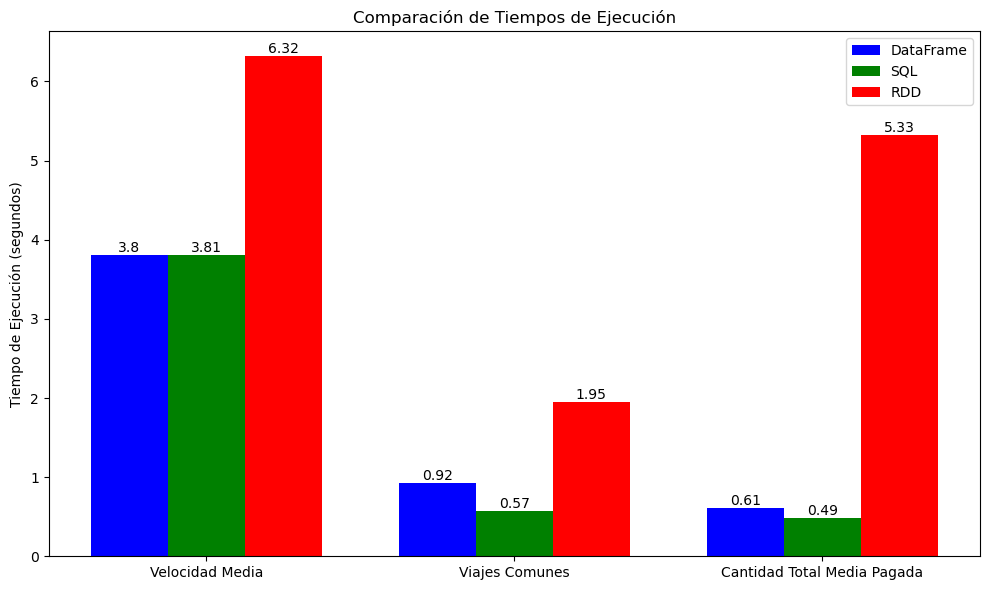

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de tiempos de ejecución
labels = ['Velocidad Media', 'Viajes Comunes', 'Cantidad Total Media Pagada']
df_times = [elapsed_time_avg_speed_df, elapsed_time_common_df, elapsed_time_total_df]
sql_times = [elapsed_time_avg_speed_sql, elapsed_time_common_sql, elapsed_time_total_sql]
rdd_times = [elapsed_time_avg_speed_rdd, elapsed_time_common_rdd, elapsed_time_total_rdd]

# Configuración de la gráfica
x = np.arange(len(labels))  # la ubicación de las etiquetas
width = 0.25  # el ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, df_times, width, label='DataFrame', color='b')
bars2 = ax.bar(x, sql_times, width, label='SQL', color='g')
bars3 = ax.bar(x + width, rdd_times, width, label='RDD', color='r')

# Añadimos etiquetas, título y personalizamos la gráfica
ax.set_ylabel('Tiempo de Ejecución (segundos)')
ax.set_title('Comparación de Tiempos de Ejecución')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Etiquetas en las barras
for bars in (bars1, bars2, bars3):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### Análisis de Resultados del Gráfico de Comparación de Tiempos de Ejecución

- Al observar esta gráfica, es evidente la diferencia significativa en los tiempos de consulta entre RDDs y los enfoques de DataFrames y Spark SQL. Esta disparidad en el rendimiento se debe principalmente a que tanto Spark SQL como los DataFrames aprovechan el optimizador de consultas Catalyst, que aplica una variedad de optimizaciones a las consultas. Estas optimizaciones incluyen el reordenamiento de operaciones, la fusión de etapas y la eliminación de cálculos redundantes, lo que permite una ejecución más eficiente de las consultas. En cambio, los RDDs en Apache Spark utilizan un enfoque basado en grafos para optimizar las transformaciones, pero sus optimizaciones son más limitadas y menos específicas en comparación con las aplicadas a los DataFrames y Spark SQL.

- La consulta de **"Cantidad Total Media Pagada"** muestra una diferencia particularmente alta en el tiempo de ejecución de los RDDs frente a los otros dos métodos. Esto se debe probablemente a la naturaleza de la consulta, que involucra cálculos complejos de agregación que Catalyst optimiza eficientemente en SQL y DataFrames. Al realizar esta consulta con RDDs, usamos `reduceByKey` para sumar el monto total pagado y contar las ocurrencias para cada número de pasajeros, mediante una operación como `reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))`. Esta operación, aunque efectiva, es más costosa en términos de tiempo de ejecución porque Spark no puede aplicar las mismas optimizaciones de Catalyst, lo que se traduce en un tiempo de procesamiento significativamente mayor.

- En general, los enfoques de **DataFrames y Spark SQL** son altamente recomendables para consultas de análisis en Spark, ya que el optimizador Catalyst reduce los tiempos de ejecución de manera significativa en comparación con los RDDs. Mientras que los RDDs pueden ser útiles para transformaciones personalizadas que requieren un control granular, resultan menos eficientes para cálculos complejos de agregación y deberían usarse principalmente en casos donde Catalyst no pueda aplicar optimizaciones adicionales.

### 6.2 Análisis del speedup

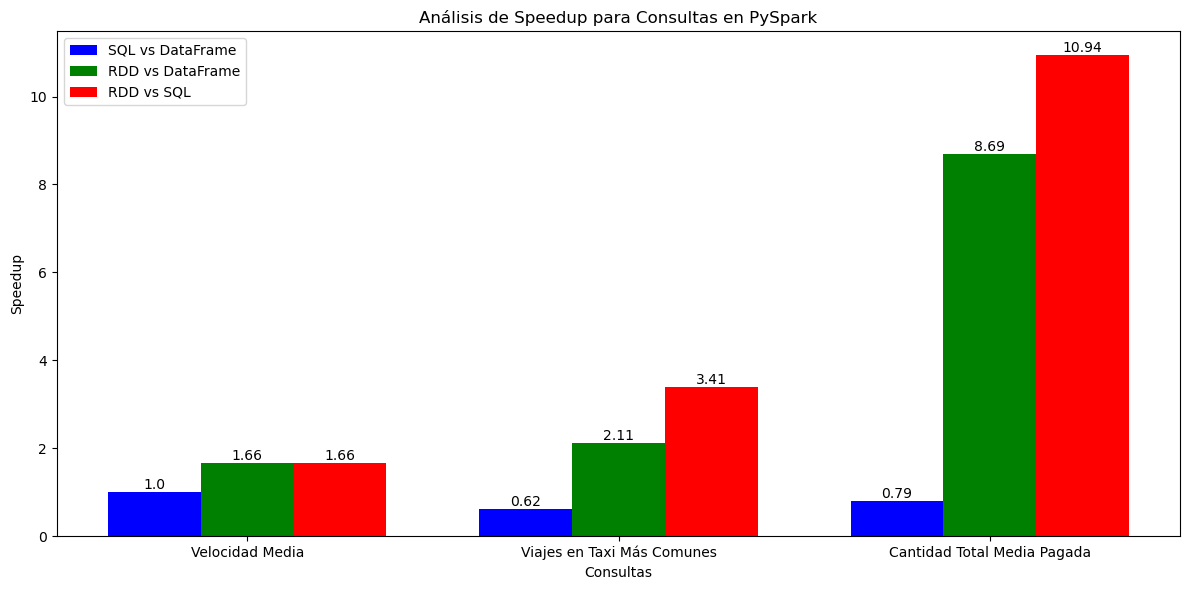

In [25]:
import pandas as pd
# Datos de tiempo de ejecución
data = {
    "Consulta": [
        "Velocidad Media",
        "Viajes en Taxi Más Comunes",
        "Cantidad Total Media Pagada"
    ],
    "DataFrame (segundos)": [
        elapsed_time_avg_speed_df,
        elapsed_time_common_df,
        elapsed_time_total_df
    ],
    "SQL (segundos)": [
        elapsed_time_avg_speed_sql,
        elapsed_time_common_sql,
        elapsed_time_total_sql
    ],
    "RDD (segundos)": [
        elapsed_time_avg_speed_rdd,
        elapsed_time_common_rdd,
        elapsed_time_total_rdd
    ]
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Calcular el speedup
df["Speedup (SQL vs DataFrame)"] = df["SQL (segundos)"] / df["DataFrame (segundos)"]
df["Speedup (RDD vs DataFrame)"] = df["RDD (segundos)"] / df["DataFrame (segundos)"]
df["Speedup (RDD vs SQL)"] = df["RDD (segundos)"] / df["SQL (segundos)"]

# Graficar el speedup
plt.figure(figsize=(12, 6))

# Configuración de los gráficos
bar_width = 0.25
index = np.arange(len(df))

# Barras para el speedup
bars1 = plt.bar(index, df["Speedup (SQL vs DataFrame)"], bar_width, label="SQL vs DataFrame", color='b')
bars2 = plt.bar(index + bar_width, df["Speedup (RDD vs DataFrame)"], bar_width, label="RDD vs DataFrame", color='g')
bars3 = plt.bar(index + 2 * bar_width, df["Speedup (RDD vs SQL)"], bar_width, label="RDD vs SQL", color='r')

# Agregar los valores en cada barra
for bar in bars1 + bars2 + bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Personalizar el gráfico
plt.xlabel('Consultas')
plt.ylabel('Speedup')
plt.title('Análisis de Speedup para Consultas en PySpark')
plt.xticks(index + bar_width, df["Consulta"])
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

`PÁRRAFO EXPLICANDO EL SPEEDUP`

## 7. Análisis del rendimiento en base al número de cores utilizado

En esta sección, se lleva a cabo un análisis exhaustivo del impacto que tiene la variación en el número de cores utilizados en el rendimiento de las consultas ejecutadas con Apache Spark. Para ello, modificamos el parámetro `local[]` en la configuración de la `SparkSession`, lo que nos permite asignar diferentes cantidades de cores al procesamiento. Dado que el kernel debe ser reiniciado cada vez que se realiza un cambio en esta configuración, registramos los resultados del tiempo de ejecución en archivos externos para asegurar que la información se conserve y se pueda analizar posteriormente. Además, se analizará el speedup obtenido en función del número de cores utilizados, proporcionando una visión clara sobre cómo la paralelización afecta a la eficiencia y rendimiento de nuestras operaciones.

Guardamos los tiempos para el número de cores en cuestión

In [26]:
import json

# Datos de tiempo de ejecución
data = {
    "Consulta": [
        "Velocidad Media",
        "Viajes en Taxi Más Comunes",
        "Cantidad Total Media Pagada"
    ],
    "DataFrame (segundos)": [
        elapsed_time_avg_speed_df,
        elapsed_time_common_df,
        elapsed_time_total_df
    ],
    "SQL (segundos)": [
        elapsed_time_avg_speed_sql,
        elapsed_time_common_sql,
        elapsed_time_total_sql
    ],
    "RDD (segundos)": [
        elapsed_time_avg_speed_rdd,
        elapsed_time_common_rdd,
        elapsed_time_total_rdd
    ]
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Guardar el DataFrame en un archivo JSON
df.to_json(f'tiempos_ejecucion_{cores}_cores.json')

print(f"Los datos han sido guardados en tiempos_ejecucion_{cores}_cores.json")

Los datos han sido guardados en tiempos_ejecucion_3_cores.json


`EJECUTAR TODO MODIFICANDO LA VARIABLE cores (arriba del todo) Y ANALIZAR LA VARIACIÓN DE LOS TIEMPOS Y EL SPEEDUP!`

## 8. Conclusiones

`sacar conclusiones`